In [311]:
import pandas as pd
import numpy as np
import seaborn as sn
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor 

In [312]:
df=pd.read_excel('Data_train.xlsx')
df.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Cleaning the Data 

In [313]:
df.tail(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648
10682,Air India,9/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,10:55,19:15,8h 20m,2 stops,No info,11753


In [314]:
df = df.drop_duplicates()

In [315]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [316]:
df=df.dropna(subset=['Route','Total_Stops'])

In [317]:
df['Additional_Info'].value_counts()

Additional_Info
No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

We don't need Additional info and We already know the source , destination and stops . So Route is also not required 

In [318]:
df = df.drop(['Additional_Info'],axis=1)


## Feature Engineering 

- Converting the Date C

In [319]:
df['Day_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format= "%d/%m/%Y").dt.day
df['Month_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format= "%d/%m/%Y").dt.month

In [320]:
df['Dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute

C:\Users\santj\AppData\Local\Temp\ipykernel_14996\3804065798.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\santj\AppData\Local\Temp\ipykernel_14996\3804065798.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [321]:
df['Arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute

C:\Users\santj\AppData\Local\Temp\ipykernel_14996\1324446684.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\santj\AppData\Local\Temp\ipykernel_14996\1324446684.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [322]:
df = df.drop(['Dep_Time','Arrival_Time','Date_of_Journey'],axis=1)

In [323]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,13302,1,3,16,50,21,35


In [324]:
s='19h'
#h=s.split()[0][:-1]
#m=s.split()[1][:-1]
d=s[:-1]
d

'19'

In [325]:
import re

def duration_hours(d):
    hours_match = re.search(r'(\d+)h', d)
    if hours_match:
        return int(hours_match.group(1))
    else:
        return 0

def duration_mins(d):
    mins_match = re.search(r'(\d+)m', d)
    if mins_match:
        return int(mins_match.group(1))
    else:
        return 0

df['Duration_hours'] = df['Duration'].apply(lambda x: duration_hours(x))
df['Duration_mins'] = df['Duration'].apply(lambda x: duration_mins(x))



In [326]:
df.head(7)

,Airline,Source,Destination,Route,Duration,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,13302,1,3,16,50,21,35,4,45
5,SpiceJet,Kolkata,Banglore,CCU → BLR,2h 25m,non-stop,3873,24,6,9,0,11,25,2,25
6,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,15h 30m,1 stop,11087,12,3,18,55,10,25,15,30


In [327]:
df['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [328]:
s='0 st'
s[:1]

'0'

In [329]:
def stops(value):
    if('n' in value):
        return 0
    else:
        return int(value[:1])
df['Total_Stops'] = df['Total_Stops'].apply(lambda x : stops(x))

In [330]:
df['Total_Stops'].unique()


array([0, 2, 1, 3, 4], dtype=int64)

## Gaining insights through Graph

In [331]:
df['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [332]:
df['Month_of_Journey'].unique()

array([3, 5, 6, 4])

In [333]:
df['Route'].nunique()

128

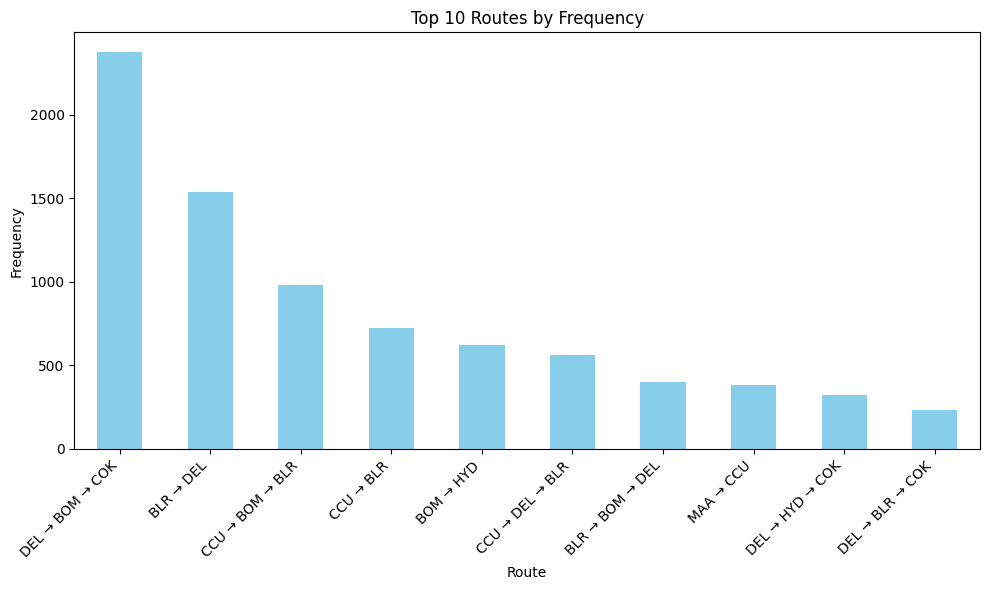

In [334]:
route_frequency = df['Route'].value_counts()

# Extract top 10 unique routes
top_10_routes = route_frequency.head(10)

# Plotting bar graph
plt.figure(figsize=(10, 6))
top_10_routes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Routes by Frequency')
plt.xlabel('Route')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

#### - Now you can see the Price Range of Each Month with Specific Airlines 

In [335]:
import plotly.express as px
import pandas as pd

# Filter data for specific airlines
specific_airlines = ['Air India', 'Jet Airways', 'SpiceJet',
                     'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
                     'Vistara Premium economy']
df_specific = df[df['Airline'].isin(specific_airlines)]

# Calculate average price for each airline in each month
df_avg_price = df_specific.groupby(['Month_of_Journey', 'Airline'])['Price'].mean().reset_index()

# Plot using Plotly
fig = px.line(df_avg_price, x='Month_of_Journey', y='Price', color='Airline', 
              title='Price vs. Month of Journey for Specific Airlines',
              labels={'Month_of_Journey': 'Month of Journey', 'Price': 'Price ($)'},
              markers=True, width=1000, height=600)

fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show()


In [336]:
df['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

### Deciding what type of Encoding to use with the help of Graphs

In [337]:
import plotly.express as px

fig = px.box(df, y="Price", x="Airline", title="Boxen Plot of Price by Airline",
             height=600, width=1200)
fig.update_layout(xaxis=dict(title='Airline'),
                  yaxis=dict(title='Price ($)'))
fig.show()


c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



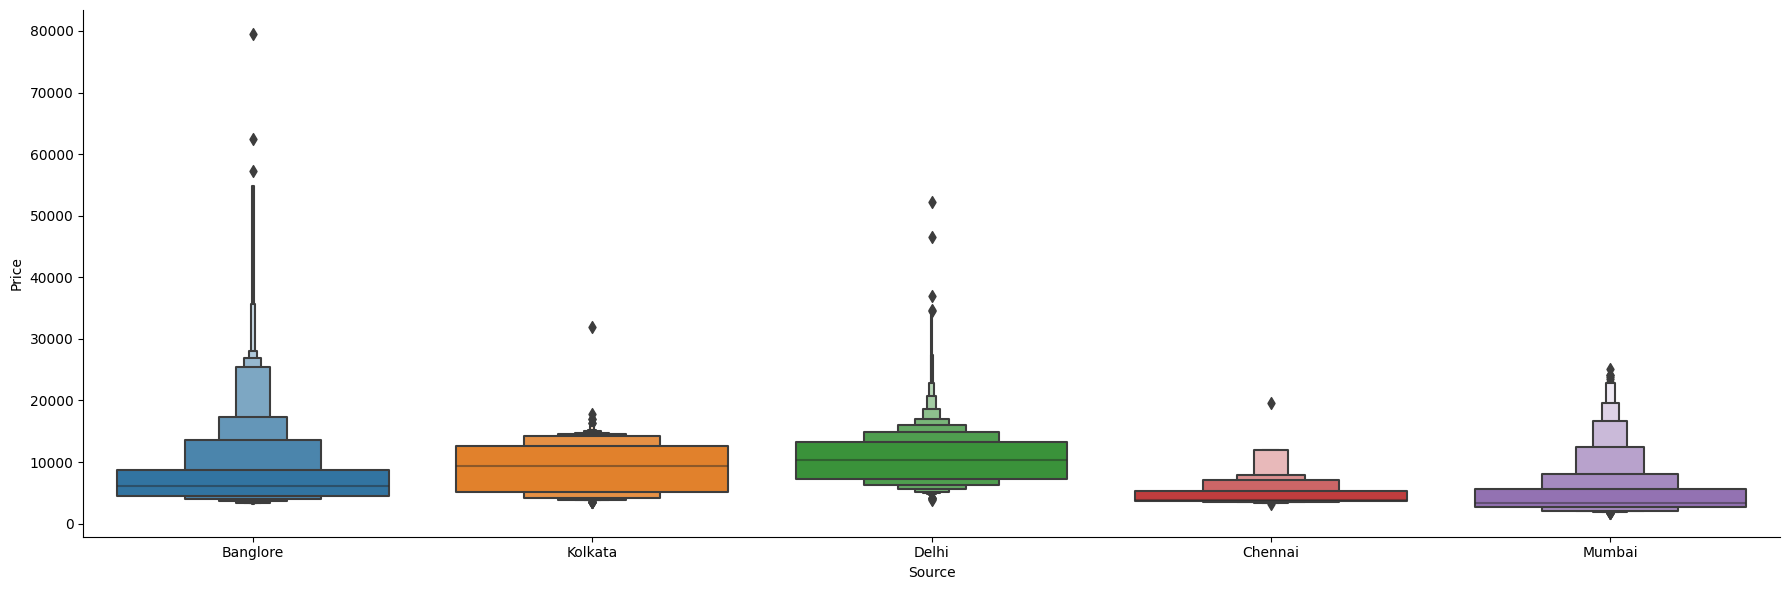

In [338]:
sn.catplot(y = "Price", x = "Source", data = df, kind="boxen", height = 6, aspect = 3)

c:\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



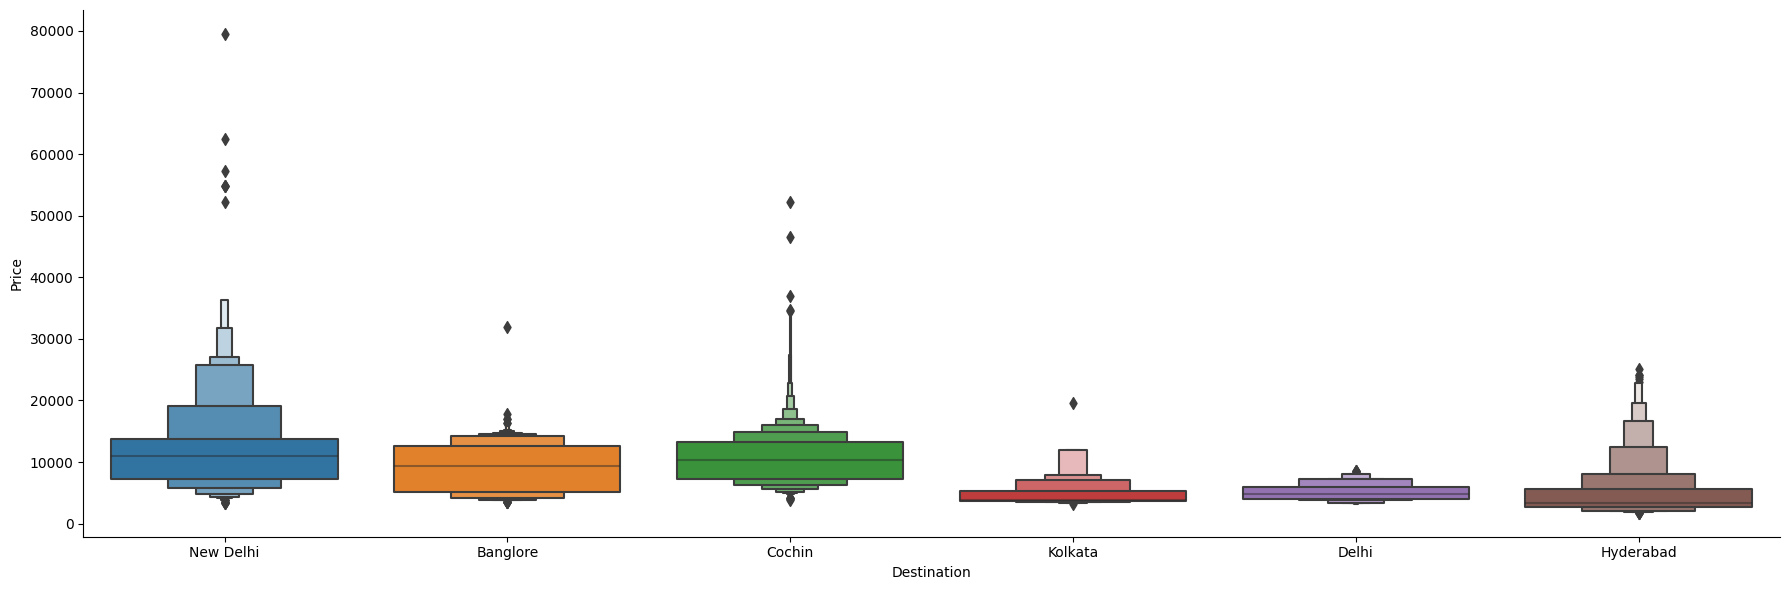

In [339]:
sn.catplot(y = "Price", x = "Destination", data = df, kind="boxen", height = 6, aspect = 3)

#### For all the three columns many of them have similar range and the minor differences between them are due to other factors so we will do Nominal Encoding on all the three features so that we'll get a better accuracy

In [340]:
Airline = df[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)

Source = df[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)

Destination = df[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)


In [341]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1,13302,1,3,16,50,21,35,4,45


### - Dropping irrelevent columns 

In [342]:
df = pd.concat([df, Airline, Source, Destination], axis = 1)
df = df.drop(['Airline','Source','Destination','Duration','Route'],axis=1)

In [343]:
df.columns

Index(['Total_Stops', 'Price', 'Day_of_Journey', 'Month_of_Journey',
       'Dep_hour', 'Dep_min', 'Arr_hour', 'Arr_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [344]:
df.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Dep_hour,Dep_min,Arr_hour,Arr_min,Duration_hours,Duration_mins,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,False,False,False,False,False,False,False,False,False,True
1,2,7662,1,5,5,50,13,15,7,25,...,False,False,False,True,False,False,False,False,False,False
2,2,13882,9,6,9,25,4,25,19,0,...,False,False,True,False,False,True,False,False,False,False
3,1,6218,12,5,18,5,23,30,5,25,...,False,False,False,True,False,False,False,False,False,False
4,1,13302,1,3,16,50,21,35,4,45,...,False,False,False,False,False,False,False,False,False,True


In [345]:
from sklearn.model_selection import train_test_split
X = df.drop(['Price'],axis=1)
y = df[['Price']]
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size = 0.2, random_state = 42)

In [346]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [347]:
df.shape

(10462, 30)

#### - Using Adaboost Regessor 

In [348]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

# Create AdaBoost Regressor
adaboost_regressor = AdaBoostRegressor()

# Fit the model on training data
adaboost_regressor.fit(X_train_s, y_train)

# Make predictions
y_pred_adaboost = adaboost_regressor.predict(X_test_s)

# Calculate R-squared score
r2_adaboost = r2_score(y_test, y_pred_adaboost)
print("R-squared Score for AdaBoost:", r2_adaboost)


c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



R-squared Score for AdaBoost: 0.27617620565646606


#### - Using Gradient Boost Regessor 

In [349]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Create Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor()

# Fit the model on training data
gb_regressor.fit(X_train_s, y_train)

# Make predictions
y_pred_gb = gb_regressor.predict(X_test_s)

# Calculate R-squared score
r2_gb = r2_score(y_test, y_pred_gb)
print("R-squared Score for Gradient Boosting:", r2_gb)


c:\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



R-squared Score for Gradient Boosting: 0.7579642545936909


#### - Using XGBoost Regressor 

In [350]:
import xgboost as xgb

# Create XGBoost Regressor
xgb_regressor = xgb.XGBRegressor()

# Fit the model on training data
xgb_regressor.fit(X_train_s, y_train)

# Make predictions
y_pred_xgb = xgb_regressor.predict(X_test_s)

# Calculate R-squared score
r2_xgb = r2_score(y_test, y_pred_xgb)
print("R-squared Score for XGBoost:", r2_xgb)


R-squared Score for XGBoost: 0.8389344423788904


In [351]:
# {'n_estimators': 100,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 17}

 # These parametersgave us an accuracy above 83

In [352]:
import pickle
# open a file, where you want to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(reg_rf, file)
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)